# Классификация комментариев

**Заказчик**: Интернет-магазин «Викишоп».

Интернет-магазин запускает новый сервис, где пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.


**Входные данные**: набор данных с разметкой о токсичности правок.

**Задача:** обучить модель классифицировать комментарии на позитивные и негативные. Значением метрики качества F1 не меньше 0.75.

Параметры:
- text - текст комментария,
- toxic - целевой признак.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Лемматизация-или-стемминг?" data-toc-modified-id="Лемматизация-или-стемминг?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Лемматизация или стемминг?</a></span></li><li><span><a href="#Разделение-на-обучающую,-валидационную-и--тестовую--выборки" data-toc-modified-id="Разделение-на-обучающую,-валидационную-и--тестовую--выборки-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Разделение на обучающую, валидационную и  тестовую  выборки</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#Создание-моделей" data-toc-modified-id="Создание-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание моделей</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li></ul></li><li><span><a href="#BERT-и-LogisticRegression" data-toc-modified-id="BERT-и-LogisticRegression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>BERT и LogisticRegression</a></span><ul class="toc-item"><li><span><a href="#Предобработка-с-использованием-модели-DistilBERT" data-toc-modified-id="Предобработка-с-использованием-модели-DistilBERT-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Предобработка с использованием модели DistilBERT</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Обзор данных

Для начала импортируем необходимые в работе библиотеки.

In [1]:
#!pip install catboost

In [2]:
#!pip install transformers

In [3]:
#!pip install torch

In [4]:
import pandas as pd
import numpy as np
import math 
pd.options.mode.chained_assignment = None

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

from IPython.display import display
from tqdm.notebook import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
import time
from datetime import timedelta
import matplotlib.pyplot as plt

#библиотеки для преобразования текста
import re
import string
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 


#библиотеки для моделирования
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from sklearn.utils import shuffle

#BERT
import torch
import transformers as ppb

import warnings
warnings.filterwarnings('ignore')

<ipython-input-4-3c6f4a55ba75>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
/Users/galina/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
[nltk_data] Downloading package punkt to /Users/galina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/galina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/galina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/galina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is alre

Сохраним данные в таблицу.

In [5]:
df = pd.read_csv('toxic_comments.csv')


Посмотрим общую информацию об исходных данных.

In [6]:
display(df.head())
display(df.info(memory_usage='deep'))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 80.1 MB


None

Таблица с исходными данными **df** содержит 159571 строк и 2 столбца, пропуски отсутствуют.

Посмотрим на распределение целевого признака.


In [7]:
df['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Видим, что классы не сбалансированные.

##  Подготовка данных

Подготовим данные для моделирования, для этого:
- лемматизируем комментарии;
- разделим выборки на обучающую (60%), валидационную(20%) и тестовую (20%);
- выделим корпус на обучающих данных и вычислим TF-IDF. 

### Лемматизация или стемминг?

Для того, чтобы определиться с методом предобработки текста (лемматизация с использованием "POS tag" (к какой части речи относится слово) или сетмминг), который будем использовать для предобработки комментариев, сравним их результаты. 

Для начала напишем функции для очистки текста от лишних символов, используя регулярные выражения, а также функцию, которая будет возвращать "POS tag" для слова.

In [8]:
def clear_text(text):
    '''Очищает текст от лишних символов и приводит к нижнему регистру'''
    #text_re = re.sub(r'[^\w ]',' ',text) A-Fa-f
    text_re = re.sub(r'[\W \d]',' ',text)
    text_split = text_re.lower().split()
    text_list = ' '.join(text_split)
    
    return text_list

def get_wordnet_pos(word):
    """Определяет POS tag для слова, основываясь на словаре tag_dict"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

Сразу инициализируем необходимые функции для лемматизации, стемминга и список стоп-слов.

In [9]:
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer(language="english")
lemmatizer = WordNetLemmatizer()

Сравним лемматизацию и стемминг на одном комментарии. Для начала очистим текст от лишних символов, токенизируем по словам и уберем стоп-слова.

In [10]:
#очищает текст от лишних символов
text_clear = clear_text(df.loc[2,'text'])
print('Текст без лишних символов:',
      '\n',
      text_clear,
     '\n-------------------------------')

#токенизирует по словам
text_token = word_tokenize(text_clear)
print('Токенизированный текст:',
      '\n',
      text_token,
     '\n-------------------------------')

#убирает стоп-слова
text_token_without_stop_words = [
    word for word in text_token if word not in stop_words
]
print('Токенизированный текст без стоп-слов:',
      '\n',
      text_token_without_stop_words,
     '\n-------------------------------')


Текст без лишних символов: 
 hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info 
-------------------------------
Токенизированный текст: 
 ['hey', 'man', 'i', 'm', 'really', 'not', 'trying', 'to', 'edit', 'war', 'it', 's', 'just', 'that', 'this', 'guy', 'is', 'constantly', 'removing', 'relevant', 'information', 'and', 'talking', 'to', 'me', 'through', 'edits', 'instead', 'of', 'my', 'talk', 'page', 'he', 'seems', 'to', 'care', 'more', 'about', 'the', 'formatting', 'than', 'the', 'actual', 'info'] 
-------------------------------
Токенизированный текст без стоп-слов: 
 ['hey', 'man', 'really', 'trying', 'edit', 'war', 'guy', 'constantly', 'removing', 'relevant', 'information', 'talking', 'edits', 'instead', 'talk', 'page', 'seems', 'care', 'formatting', 'actual', 'info'] 
-------------------------------


Теперь сравним результат, выдаваемый лемматизацией и стеммингом.

In [11]:
#стемминг
stem_text = [stemmer.stem(word) for word in text_token_without_stop_words]
print('Стемминг:',
      '\n',
      stem_text,
     '\n-------------------------------')

#лемматизация с учетом POS tag
lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_token_without_stop_words]
print('Лемматизация с учетом POS tag:',
      '\n',
      lemma)

Стемминг: 
 ['hey', 'man', 'realli', 'tri', 'edit', 'war', 'guy', 'constant', 'remov', 'relev', 'inform', 'talk', 'edit', 'instead', 'talk', 'page', 'seem', 'care', 'format', 'actual', 'info'] 
-------------------------------
Лемматизация с учетом POS tag: 
 ['hey', 'man', 'really', 'try', 'edit', 'war', 'guy', 'constantly', 'remove', 'relevant', 'information', 'talk', 'edits', 'instead', 'talk', 'page', 'seem', 'care', 'format', 'actual', 'info']


Видим, что для слова "trying" стемминг выдал - "tri", а лемматизация с учетом POS tag - "try". Аналогичную ситуацию наблюдаем и по другим словам, например: "removing", "relevant" и др.

Результаты, получаемые при лемматизации, кажутся более верным решением. Будем использовать ее для предобработки текста. Напишем функцию для лемматизации.

In [12]:
def lemm_text(text):
    '''Возвращает лемматизированный список слов, очищенный от лишних символов и стоп-слов'''
    #очищает текст от лишних символов
    text_clear = clear_text(text)
    #токенизирует по словам
    text_token = word_tokenize(text_clear)
    #убирает стоп-слова
    text_token_without_stop_words = [
        word for word in text_token if word not in stop_words
    ]
    #лемматизирует, учитывая POS tag
    lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_token_without_stop_words]
    
    return " ".join(lemma)

Проверим ее работу.

In [13]:
lemm_text(df.loc[0,'text'])

'explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire'

Выглядит корректно.  С ее помощью создадим параметр **'lem_text'**. используя метод `apply`.

In [14]:
df['lemm_text'] = df['text'].progress_apply(lambda x: lemm_text(x))

Выведем 5 первых строк таблицы.

In [15]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


Отлично, комментарии очистили и лемматизировали. Разделим данные на выборки.

**Промежуточные выводы:** приняли решение использовать при предобработки комментариев лемматизацию. Ее результат выглядит более корректным для целей проекта.

### Разделение на обучающую, валидационную и  тестовую  выборки

Разделим выборки на обучающую (60%), валидационную(20%) и тестовую (20%). Чтобы выборки были репрезентативные, используем стратификацию.

In [16]:
#выделяет тестовую выборку
df_train, test = train_test_split(df, test_size=0.2, random_state=13, stratify=df['toxic'])

#выделяет обучающую и валидационную выборки
train, valid = train_test_split(df_train, test_size=0.25, random_state=13, stratify=df_train['toxic'])

#выделяет признаки и целевой признак
#features_train = train['lemm_text']
target_train = train['toxic']

#features_valid = valid['lemm_text']
target_valid = valid['toxic']

#features_test = test['lemm_text']
target_test = test['toxic']

Проверим, как разделились данные.

In [17]:
print('Проверка размера полученных выборок:',
     '\n')
print('Исходный размер таблицы:', df.shape)
    
for data in [train, target_train, valid, target_valid, test, target_test]:
    name =[x for x in globals() if globals()[x] is data][0]
    print('Размер таблицы',name,':', data.shape)
    
print('',
    '\nДоля обучающей выборки от исходной таблицы: {:.0%}'.format(train.shape[0]/len(df)))
print('Доля валидационной выборки от исходной таблицы: {:.0%}'.format(valid.shape[0]/len(df)))
print('Доля тестовой выборки от исходной таблицы: {:.0%}'.format(test.shape[0]/len(df)),
     '\n')

print('Проверка долей каждой группы в полученных выборках:')
for data in [train, valid, test]:
    name =[x for x in globals() if globals()[x] is data][0]
    print('\n',name)
    display(data['toxic'].value_counts(normalize=True).to_frame())

Проверка размера полученных выборок: 

Исходный размер таблицы: (159571, 3)
Размер таблицы train : (95742, 3)
Размер таблицы target_train : (95742,)
Размер таблицы valid : (31914, 3)
Размер таблицы target_valid : (31914,)
Размер таблицы test : (31915, 3)
Размер таблицы target_test : (31915,)
 
Доля обучающей выборки от исходной таблицы: 60%
Доля валидационной выборки от исходной таблицы: 20%
Доля тестовой выборки от исходной таблицы: 20% 

Проверка долей каждой группы в полученных выборках:

 train


,toxic
0,0.89832
1,0.10168



 valid


,toxic
0,0.89832
1,0.10168



 test


,toxic
0,0.898324
1,0.101676


Данные разделены корректно, соотношение групп по целевому признаку соблюдены. Теперь можно перейти к расчету TF-IDF.


**Промежуточные выводы:** выделили три выборки: обучающая (60%)б валидационная (20%) и тестовая (20%).

### TF-IDF

Сформируем корпус из лемматизированных комментариев обучающей выборки и рассчитаем TF-IDF для всех трех выборок.

In [18]:
#формирует корпус на основе обучающей выборки
corpus = train['lemm_text'].values.astype('U')

#создает счетчик и обучается
count_tf_idf = TfidfVectorizer() 
features_train = count_tf_idf.fit_transform(corpus)

#формирует признаки для валидационной и тестовой выборок
features_valid = count_tf_idf.transform(valid['lemm_text'].values.astype('U')) 
features_test = count_tf_idf.transform(test['lemm_text'].values.astype('U')) 

print("Размер матрицы:", features_train.shape)
print("Размер матрицы:", features_valid.shape)
print("Размер матрицы:", features_test.shape)

Размер матрицы: (95742, 116017)
Размер матрицы: (31914, 116017)
Размер матрицы: (31915, 116017)


Перейдем к созданию моделей.

**Промежуточные выводы:** сформировали признаки для всех трех выборок, рассчитав TF-IDF для каждого комментария.

## Создание моделей

Создадим и обучим четыре модели: 
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier
- CatBoostClassifier
 

### Logistic Regression

Первой построим модель логистической регрессии с использованием кросс-валидации. Проблему с дисбалансом классов решим их взвешиванием, указав в модели параметр `class_weight` равный **'balanced'**.

In [19]:
model_logistic = LogisticRegressionCV(cv=5, random_state=13, solver='liblinear', class_weight='balanced')

#обучение модели
start_log_train = time.time()
model_logistic.fit(features_train, target_train)
end_log_train = time.time()

time_log_train = str(timedelta(seconds=(end_log_train-start_log_train)))

Напишем функцию для получения предсказаний и метрики, а также времени предсказания. Применим ее на валидационной выборке.

In [20]:
def pred_with_time(model, features, target):
    '''Возвращает F1-меру и время предсказания'''
    start = time.time()
    prediction = model.predict(features)
    end = time.time()
    
    time_pred = str(timedelta(seconds=(end-start)))

    f1 = f1_score(target, prediction)
    print('F1-мера: {:.3f}'.format(f1),
         '\nВремя предсказания:',time_pred)
    
    return f1, time_pred

f1_valid_logistic, time_log_pred_valid = pred_with_time(model_logistic, features_valid, target_valid)

F1-мера: 0.764 
Время предсказания: 0:00:00.002344


На валидационной выборке получили значение F1-меры равное 0.764. Теперь получим метрику для тестовой выборки.

In [21]:
f1_test_logistic, time_log_pred_test = pred_with_time(model_logistic, features_test, target_test)

F1-мера: 0.756 
Время предсказания: 0:00:00.002983


На тестовой выборке получили F1-меры равное 0.756. Метрика на валидационной и тестовой выборках не сильно отличается. Сформируем итоговую таблицу по всем моделям.

In [22]:
result = pd.DataFrame({"Model": ["LogisticRegression"],
                       "F1 valid": [f1_valid_logistic], 
                       "F1 test": [f1_test_logistic],
                       "Time grid/train": [time_log_train],
                       "Time prediction valid": [time_log_pred_valid],
                       "Time prediction test": [time_log_pred_test],
                       
                      })

result

,Model,F1 valid,F1 test,Time grid/train,Time prediction valid,Time prediction test
0,LogisticRegression,0.763848,0.756459,0:01:08.553059,0:00:00.002344,0:00:00.002983


Первая обученная модель выдает необходимую нам метрику, при этом обучение занимает чуть больше 1 минуты, а предсказывает достаточно быстро.

Перейдем к следующей модели.

### DecisionTreeClassifier

Построим модель решающее дерево и с помощью функции `GridSearchCV` подберем параметры. 

Создадим через функцию KFold условия для выборок в кросс-валидации.

In [23]:
shuffle = KFold(n_splits=5, random_state=13, shuffle=True)

Построим модель, также указав параметр `class_weight` равный **'balanced'**.

In [24]:
%%time
estimator_tree = DecisionTreeClassifier(random_state=13,
                                    class_weight='balanced')


CPU times: user 11.7 ms, sys: 5.88 ms, total: 17.6 ms
Wall time: 3.21 ms


Создадим список перебираемых параметров и передадим их в `GridSearchCV`.

In [25]:
#список перебираемых параметров
param_tree = {'max_depth': np.arange(13, 14, 1),
              'min_samples_split': np.arange(2, 3, 1),
              'min_samples_leaf': np.arange(2, 3, 1)}


start_tree_grid_train = time.time()
#подбирает гиперпараметры
model_tree = GridSearchCV(estimator_tree, param_tree, scoring='f1', cv=shuffle)

#обучает модель
model_tree.fit(features_train, target_train)
end_tree_grid_train= time.time()

#время обучения
#time_tree_grid_train=str(timedelta(seconds=(end_tree_grid_train-start_tree_grid_train)))
time_tree_grid_train='0:23:46.792794'

print('F1-мера: {:.3f}'.format(model_tree.best_score_))
print('Лучшие параметры',model_tree.best_params_)
print('Время train:', time_tree_grid_train)

F1-мера: 0.608
Лучшие параметры {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 2}
Время train: 0:23:46.792794


Для модели DecisionTreeClassifier получили лучшее значение F1-меры равное 0.609 при следующих гиперпараметрах:
- `max_depth`: 13
- `min_samples_leaf`: 2, 
- `min_samples_split`: 2.


Получим предсказание и метрику для валидационной выборки.

In [26]:
f1_valid_tree, time_tree_pred_valid = pred_with_time(model_tree, features_valid, target_valid)

F1-мера: 0.615 
Время предсказания: 0:00:00.013638


На валидационной выборке получили значение F1-меры равное 0.615. Теперь получим метрику для тестовой выборки.

In [27]:
f1_test_tree, time_tree_pred_test = pred_with_time(model_tree, features_test, target_test)

F1-мера: 0.591 
Время предсказания: 0:00:00.012319


На тестовой выборке получили F1-меру равную 0.591.  Сформируем итоговую таблицу по всем моделям.

In [28]:
result = result.append({"Model": "DecisionTreeClassifier",
                       "F1 valid": f1_valid_tree, 
                       "F1 test": f1_test_tree,
                       "Time grid/train": time_tree_grid_train,
                       "Time prediction valid": time_tree_pred_valid,
                       "Time prediction test": time_tree_pred_test}, ignore_index=True)

result.sort_values(by='F1 test')

,Model,F1 valid,F1 test,Time grid/train,Time prediction valid,Time prediction test
1,DecisionTreeClassifier,0.614799,0.591169,0:23:46.792794,0:00:00.013638,0:00:00.012319
0,LogisticRegression,0.763848,0.756459,0:01:08.553059,0:00:00.002344,0:00:00.002983


Результат модели дерева решений хуже, чем у логистической регрессии, при этом время обучения и предсказания у значительно превышает модель логистической регрессии.

### RandomForestClassifier

Построим модель RandomForestRegressor и подберем гиперпараметры с помощью функции GridSearchCV.

In [29]:
model_forest = RandomForestClassifier(random_state=13, class_weight='balanced', n_estimators=400) 

#формирует гиперпараметры и их значения для перебора в функции GridSearchCV
param_forest = { 
    'min_samples_split': np.arange(4, 5, 1)
    
}

Подберем гиперпараметры и обучим модель.

In [30]:
start_forest_grid_train = time.time()
#подбирает гиперпараметры
model_forest = GridSearchCV(model_forest, param_forest, scoring='f1', cv=shuffle)

#обучает модель
model_forest.fit(features_train, target_train)
end_forest_grid_train = time.time()

#время обучения
#time_forest_grid_train=str(timedelta(seconds=(end_forest_grid_train-start_forest_grid_train)))
time_forest_grid_train='0:33:46.963650'

print('F1-мера: {:.3f}'.format(model_forest.best_score_))
print('Лучшие параметры',model_forest.best_params_)

F1-мера: 0.665
Лучшие параметры {'min_samples_split': 4}


Для модели RandomForestClassifier получили лучшее значение F1-меры при гиперпараметрах, равных:
- `min_samples_split`: 4, 
- `n_estimators`: 400


Получим предсказание и метрику для валидационной выборки.

In [31]:
f1_forest_valid, time_forest_pred_valid = pred_with_time(model_forest,features_valid, target_valid)

F1-мера: 0.678 
Время предсказания: 0:00:09.981652


На валидационной выборке значение F1-меры равно 0.678. Посчитаем для тестовой выборки.

In [32]:
f1_forest_test, time_forest_pred_test = pred_with_time(model_forest,features_test, target_test)

F1-мера: 0.657 
Время предсказания: 0:00:09.791373


На тестовой выборке значение F1-меры равно 0.657. Добавим в сводную таблицу.

In [33]:
result = result.append({"Model": "RandomForestClassifier", 
                        "F1 valid": f1_forest_valid, 
                        "F1 test": f1_forest_test,
                        "Time grid/train": time_forest_grid_train,
                        "Time prediction valid": time_forest_pred_valid,
                        "Time prediction test": time_forest_pred_test}, ignore_index=True)

result.sort_values(by='F1 test')

,Model,F1 valid,F1 test,Time grid/train,Time prediction valid,Time prediction test
1,DecisionTreeClassifier,0.614799,0.591169,0:23:46.792794,0:00:00.013638,0:00:00.012319
2,RandomForestClassifier,0.678315,0.656558,0:33:46.963650,0:00:09.981652,0:00:09.791373
0,LogisticRegression,0.763848,0.756459,0:01:08.553059,0:00:00.002344,0:00:00.002983


Модель случайного леса предсказала лучше, чем модель дерева решений, но все же уступает модели логистической регрессии. Время обучения и подбора гиперпараметров самое долгое у случайного леса.

### CatBoostClassifier

Построим модель CatBoostClassifier и подберем гиперпараметры с помощью функции GridSearchCV.

Зададим веса для несбалансированных классов.

In [35]:
scale_pos_weight = round((len(target_train[target_train == 0]) / 
                          len(target_train[target_train == 1])), 3)
scale_pos_weight

8.835

In [36]:
%%time
model_cat = CatBoostClassifier(random_state = 13, verbose=100, eval_metric='F1',
                              scale_pos_weight=scale_pos_weight)


start_cat_train = time.time()
model_cat.fit(features_valid, target_valid,eval_set=(features_valid, target_valid))
end_cat_train = time.time()

#время обучения
time_cat_train=str(timedelta(seconds=(end_cat_train-start_cat_train)))


Learning rate set to 0.074541
0:	learn: 0.4638620	test: 0.4638620	best: 0.4638620 (0)	total: 331ms	remaining: 5m 30s
100:	learn: 0.8400586	test: 0.8400586	best: 0.8400586 (100)	total: 22.8s	remaining: 3m 22s
200:	learn: 0.8875162	test: 0.8875162	best: 0.8879512 (199)	total: 44.9s	remaining: 2m 58s
300:	learn: 0.9200461	test: 0.9200461	best: 0.9200461 (300)	total: 1m 7s	remaining: 2m 35s
400:	learn: 0.9373096	test: 0.9373096	best: 0.9373096 (400)	total: 1m 29s	remaining: 2m 13s
500:	learn: 0.9510829	test: 0.9510829	best: 0.9510829 (500)	total: 1m 51s	remaining: 1m 51s
600:	learn: 0.9700110	test: 0.9700110	best: 0.9701704 (599)	total: 2m 13s	remaining: 1m 28s
700:	learn: 0.9860316	test: 0.9860316	best: 0.9860316 (698)	total: 2m 35s	remaining: 1m 6s
800:	learn: 0.9883612	test: 0.9883612	best: 0.9883612 (799)	total: 2m 58s	remaining: 44.3s
900:	learn: 0.9894898	test: 0.9894898	best: 0.9895411 (893)	total: 3m 20s	remaining: 22s
999:	learn: 0.9906188	test: 0.9906188	best: 0.9906188 (994)	tot

Проверим модель на валидационной выборке.

In [37]:
f1_cat_valid, time_cat_pred_valid = pred_with_time(model_cat, features_valid, target_valid)

F1-мера: 0.924 
Время предсказания: 0:00:00.304970


На валидационной выборке значение F1-меры равно 0.924. Посчитаем для тестовой выборки.

In [38]:
f1_cat_test, time_cat_pred_test = pred_with_time(model_cat, features_test, target_test)

F1-мера: 0.747 
Время предсказания: 0:00:00.307244


На тестовой выборке значение F1-меры равно 0.747. Добавим в итоговую таблицу.

In [39]:
result = result.append({"Model": "CatBoostClassifier", 
                       "F1 valid": f1_cat_valid, 
                       "F1 test": f1_cat_test,
                       "Time grid/train": time_cat_train,
                       "Time prediction valid": time_cat_pred_valid,
                       "Time prediction test": time_cat_pred_test}, ignore_index=True)

result.sort_values(by='F1 test')

,Model,F1 valid,F1 test,Time grid/train,Time prediction valid,Time prediction test
1,DecisionTreeClassifier,0.614799,0.591169,0:23:46.792794,0:00:00.013638,0:00:00.012319
2,RandomForestClassifier,0.678315,0.656558,0:33:46.963650,0:00:09.981652,0:00:09.791373
3,CatBoostClassifier,0.923822,0.746722,0:03:45.202968,0:00:00.304970,0:00:00.307244
0,LogisticRegression,0.763848,0.756459,0:01:08.553059,0:00:00.002344,0:00:00.002983


Значение F1-меры на тестовой выборке для моделей LogisticRegression и CatBoostClassifier близки, но модель CatBoostClassifier требует гораздо больше времени на обучение.

### Проверка модели на адекватность

Проверим модели на адекватность с помощью модели **DummyClassifier**.

In [40]:
dummy_clf = DummyClassifier(random_state=13, strategy="stratified")

#обучает модель
start_dummy_train = time.time()
dummy_clf.fit(features_train, target_train)
end_dummy_train = time.time()

#время обучения
time_dummy_train=str(timedelta(seconds=(end_dummy_train-start_dummy_train)))


Посмотрим на результат модели на валидационной выборке.

In [41]:
f1_dummy_valid, time_dummy_pred_valid = pred_with_time(dummy_clf, features_valid, target_valid)

F1-мера: 0.101 
Время предсказания: 0:00:00.001671


На валидационной выборке значение F1-меры равно 0.101. Посчитаем для тестовой выборки.

In [42]:
f1_dummy_test, time_dummy_pred_test = pred_with_time(dummy_clf, features_test, target_test)

F1-мера: 0.102 
Время предсказания: 0:00:00.001417


На тестовой выборке значение F1-меры равно 0.102. Добавим результаты в сводную таблицу.

In [43]:
result = result.append({"Model": "DummyClassifier", 
                        "F1 valid": f1_dummy_valid, 
                        "F1 test": f1_dummy_test,
                        "Time grid/train": time_dummy_train,
                        "Time prediction valid": time_dummy_pred_valid,
                        "Time prediction test": time_dummy_pred_test}, ignore_index=True)

result.sort_values(by='F1 test')

,Model,F1 valid,F1 test,Time grid/train,Time prediction valid,Time prediction test
4,DummyClassifier,0.100679,0.101915,0:00:00.002179,0:00:00.001671,0:00:00.001417
1,DecisionTreeClassifier,0.614799,0.591169,0:23:46.792794,0:00:00.013638,0:00:00.012319
2,RandomForestClassifier,0.678315,0.656558,0:33:46.963650,0:00:09.981652,0:00:09.791373
3,CatBoostClassifier,0.923822,0.746722,0:03:45.202968,0:00:00.304970,0:00:00.307244
0,LogisticRegression,0.763848,0.756459,0:01:08.553059,0:00:00.002344,0:00:00.002983


Случайная модель показала самую низкую метрику из всех, отличие существенное. У рассмотренных моделей гораздо выше качество предсказания. 

**Промежуточные итоги:**

1. Необходимую метрику показала только модель LogisticRegression.

2. Результаты модели CatBoostClassifier близки к результатам модели LogisticRegression, но при этом CatBoostClassifier требует гораздо больше времени на обучение даже без подбора параметров.

2. Третий результат показала модель RandomForestClassifier, но у нее самое длительное время обучения и подбора гиперпараметров.

3. Последний результат показала модель DecisionTreeClassifier, время обучения на уровне модели CatBoostClassifier.

## BERT и LogisticRegression

### Предобработка с использованием модели DistilBERT

DistilBERT представляет собой уменьшенную версию BERT. Она быстрее и легче, но не уступает по результативности. Будем использовать ее.

Загрузим предобученную модель DistilBERT и токенайзер.

In [45]:
model_class, tokenizer_class, pretrained_weights = (
    ppb.BertModel, ppb.BertTokenizer, 'distilbert-base-uncased')

#BERT
#model_class, tokenizer_class, pretrained_weights = (
#    ppb.DistilBertModel, ppb.DistilBertTokenizer, 'bert-base-uncased')

Загрузим предобученные токенайзер и модель.

In [46]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_bert = model_class.from_pretrained(pretrained_weights)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.3.attention.q_lin.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.transformer.layer.1.output_layer_norm.weight', 'distilbert.transformer.layer.1.ffn.lin2.bias', 'distilbert.transformer.layer.2.attention.v_lin.bias', 'distilbert.transformer.layer.1.attention.out_lin.bias', 'vocab_projector.bias', 'distilbert.transformer.layer.2.atten

Выполним токенезацию комментариев.

In [47]:
df['token'] = df['text'].progress_apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Посмотрим, что у нас получилось.

In [48]:
df['token'].head()

0    [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1    [101, 1040, 1005, 22091, 2860, 999, 2002, 3503...
2    [101, 4931, 2158, 1010, 1045, 1005, 1049, 2428...
3    [101, 1000, 2062, 1045, 2064, 1005, 1056, 2191...
4    [101, 2017, 1010, 2909, 1010, 2024, 2026, 5394...
Name: token, dtype: object

Посмотрим, какя максимальная длина комментариев с токенами.

In [49]:
max_len = max([len(i) for i in df['token']])
max_len

4950

Модель DistilBERT принимает максимальное количество токенов в тексте по умолчанию равное 512. В нашем случае явное превышение этого числа. Посмотрим на распределение длин комментариев.

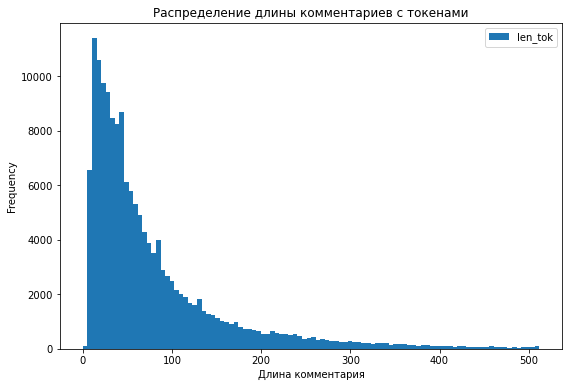

In [50]:
len_tok = pd.DataFrame([len(i) for i in df['token']], columns=['len_tok'])
len_tok.plot.hist(bins=100, range=(0,512), figsize=(9,6), xlabel='Длина комментария')

#задает форматирование
plt.xlabel('Длина комментария')
plt.title('Распределение длины комментариев с токенами')
plt.show()

Из распределения видим, что основная длина комментариев находится в диапазоне до 300 токенов. Уберем аномальные длины, в качестве порогового значения возьмем 75% квантиль.

In [51]:
print('75% квантиль длины комментариев:',len_tok.quantile(.75))

#формирует список индексов строк, в которых длина комментария не превышает пороговое значение
df['token_len'] = df['token'].apply(len)
indexes = list(df[df['token_len'] <= len_tok.quantile(.75)[0]].index)

75% квантиль длины комментариев: len_tok    104.0
Name: 0.75, dtype: float64


Чтобы хватило оперативной памяти, сформируем небольшую выборку.

In [52]:
print('Изначальный размер таблицы', df.shape)

df_bert = df.loc[indexes].copy()
print('Размер таблицы с длиной комментария до 104:',df_bert.shape)

df_bert_sample = df_bert.sample(20000,random_state=13).reset_index(drop=True)

print('Размер выборки:',df_bert_sample.shape)

Изначальный размер таблицы (159571, 5)
Размер таблицы с длиной комментария до 104: (119975, 5)
Размер выборки: (20000, 5)


Определим максимальную длину комментария из выборки для применения метода `padding`.

In [53]:
max_len = max([len(i) for i in df_bert_sample['token']])
max_len

104

Применим метод `padding`, чтобы выравнить длину векторов, заполнив недостающие значения 0.

In [54]:
padded = np.array([i + [0]*(max_len-len(i)) for i in tqdm(df_bert_sample['token'].values)])
padded.shape

(20000, 104)

Создадим маску, где укажем, что нули не несут важной информации.

In [55]:
# создадим маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [56]:
attention_mask.shape

(20000, 104)

Преобразуем тексты в эмбеддинги.

In [57]:
batch_size = 100
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

Создадим матрицу признаков.

In [58]:
features = np.concatenate(embeddings)
features = pd.DataFrame(features, index=df_bert_sample.index)
features.shape

(20000, 768)

Разделим на обучающую и тестовую выборки. Так как мы изначально взяли небольшую выборку для получения матрицы признаков, сделаем тестовую выборку размером 20%, чтобы модель могла обучиться на большем количестве данных.

In [59]:
#выделяет обучающую и тестовую выборки из матрицы признаков
features_train_bert, features_test_bert = train_test_split(features, test_size=0.2, random_state=13)
print('Размер features_train_bert',features_train_bert.shape)
print('Размер features_test_bert',features_test_bert.shape)

#формирует целевые признаки для выборок
target_train_bert = df_bert_sample.loc[(df_bert_sample.index.isin(features_train_bert.index)),'toxic']
target_test_bert = df_bert_sample.loc[(df_bert_sample.index.isin(features_test_bert.index)),'toxic']
print('Размер target_train_bert',target_train_bert.shape)
print('Размер target_train_bert',target_test_bert.shape)


features_train_bert = features_train_bert.sort_index()
target_train_bert = target_train_bert.sort_index()

features_test_bert = features_test_bert.sort_index()
target_test_bert  = target_test_bert.sort_index()


Размер features_train_bert (16000, 768)
Размер features_test_bert (4000, 768)
Размер target_train_bert (16000,)
Размер target_train_bert (4000,)


**Промежуточные итоги:**
- Токенизировали комментарии. 
- Устранили аномально длинные комметарии, в качестве порога взяв 75% квантиль. 
- Применили метод `padding`.
- Сформировали обучающую (80%) и тестовую(20%) выборки.


### LogisticRegression

Построим модель логистической регрессии с теми же параметрами, которые уже использовали ранее без применения модели BERT.

In [60]:
model_logistic_bert = model_logistic = LogisticRegressionCV(cv=5, 
                                                            random_state=13, 
                                                            solver='liblinear',
                                                            class_weight='balanced')

start_log_bert_train = time.time()
model_logistic_bert.fit(features_train_bert, target_train_bert)
end_log_bert_train = time.time()

time_log_bert_train = str(timedelta(seconds=(end_log_bert_train-start_log_bert_train)))

print('Время обучения:', time_log_bert_train)

Время обучения: 0:06:42.261472


Модель обучается в течении 5 минут. Посмотрим на значение F1-меры на тестовой выборке.

In [61]:
f1_test_logistic_bert, time_log_bert_pred_test = pred_with_time(model_logistic_bert, features_test_bert, target_test_bert)


F1-мера: 0.499 
Время предсказания: 0:00:00.016925


На тестовой выборке получили метрику F1 равной 0.499. Качество данной модели низкое. Возможно, это связано с недостаточным количеством информации и нужно увеличить размер исходной выборки.

## Вывод

**Что сделали:**
1. **Без использования модели BERT:**
    1. Очистили комментарии от лишних символов и стоп-слов, привели к нижнему регистру и токенизировали.
    2. Сравнили лемматизацию с учетом POS tag  и стемминг. Результат, полученный в процессе лемматизации, выглядит более подходящим для данной задачи, поэтому в проекте использовали лемматизацию токенов.
    3. Разделили на три выборки: обучающую (60%), валидационную(20%) и тестовую (20%). 
    4. Перевели лемматизированные комментарии в векторы и рассчитали TF-IDF.
    5. Построили 4 модели: LogisticRegressionCV, DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier. Проблему с дисбалансом классов решили их взвешиванием внутри моделей.
    6. Проверили модели на адекватность, сравнив с моделью DummyClassifier.
    
    
2. **С использованием BERT:**
    1. Использовали модель DistilBERT, так как она быстрее и легче, чем BERt, при этом не уступает в результативности.
    2. Токенизировали комментарии.
    3. Модель DistilBERT принимает максимальное количество токенов в тексте по умолчанию равное 512, в связи с чем убрали аномальные длины, в качестве порогового значения взяли 75% квантиль.
    4. Сформировали выборку из 20000 строк для последующего анализа, чтобы хватило оперативной памяти для получения результата.
    5. Применили метод `padding`, создали маску и провели эмбединг.
    6. Сформировали обучающую (80%) и тестовую(20%) выборки.
    5. Обучили модель логистической регрессии.

**Вывод:**
1. **Без использования модели BERT:**

    1. Необходимую метрику показала только модель LogisticRegression.

    2. Результаты модели CatBoostClassifier близки к результатам модели LogisticRegression, но при этом CatBoostClassifier требует гораздо больше времени на обучение даже без подбора параметров.

    3. Третий результат показала модель RandomForestClassifier, но у нее самое длительное время обучения и подбора гиперпараметров.

    4. Последний результат показала модель DecisionTreeClassifier, время обучения на уровне модели CatBoostClassifier.
    
2. **С использованием BERT:**
На тестовой выборке модель LogisticRegression получила метрику F1 равной 0.499. Качество данной модели низкое, относительно моделей без применения BERT. Возможно, это связано с недостаточным количеством информации и нужно увеличить размер исходной выборки.

**Рекомендации:**
Использовать для предсказаний модель LogisticRegression, она позволяет достигнуть требуемого качества и достаточно быстро обучается.